<a href="https://colab.research.google.com/github/shadowscythe03/es335-24-fall-assignment-2/blob/master/Task_2_audio_rconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Audio Reconstruction using RFF and Linear Regression

In [1]:
#latexify function and code:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib

from math import sqrt
SPINE_COLOR = 'gray'

def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """
    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 2.0 if columns==1 else 4.0 # width in inches

    if fig_height is None:
        golden_mean = 1/1.62  # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height +
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': '\\usepackage{gensymb}',
              'axes.labelsize': 10, # fontsize for x and y labels (was 10)
              'axes.titlesize': 10,
              'font.size': 10, # was 10
              'legend.fontsize': 10, # was 10
              'xtick.labelsize': 10,
              'ytick.labelsize': 10,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

In [2]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

latexify(columns = 2)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cm-super is already the newest version (0.3.4-17).
dvipng is already the newest version (1.15-1.1).
texlive-latex-extra is already the newest version (2021.20220204-1).
texlive-latex-recommended is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')
# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [4]:
import soundfile
%matplotlib inline
!pip install pydub
from IPython.display import Audio
Audio('/content/drive-breakbeat-173062.mp3')

In [5]:
from pydub import AudioSegment

# Load the audio file (supports formats like mp3, wav, etc.)
audio = AudioSegment.from_file("/content/drive-breakbeat-173062.mp3")

# Get the first 5 seconds (pydub works in milliseconds)
five_seconds_clip = audio[2000:7000]  # 5000 ms = 5 seconds

# Save or play the trimmed audio
five_seconds_clip.export("five_seconds_clip.wav", format="wav")  # Save as mp3


<_io.BufferedRandom name='five_seconds_clip.wav'>

In [6]:
Audio("five_seconds_clip.wav")

In [7]:
import torchaudio
audio, sr = torchaudio.load('/content/five_seconds_clip.wav')
print(sr)
print(audio.shape)
audio = audio[0]
tm = audio.shape[0] / sr
print(f"Audio length: {tm} seconds")

44100
torch.Size([2, 220500])
Audio length: 5.0 seconds


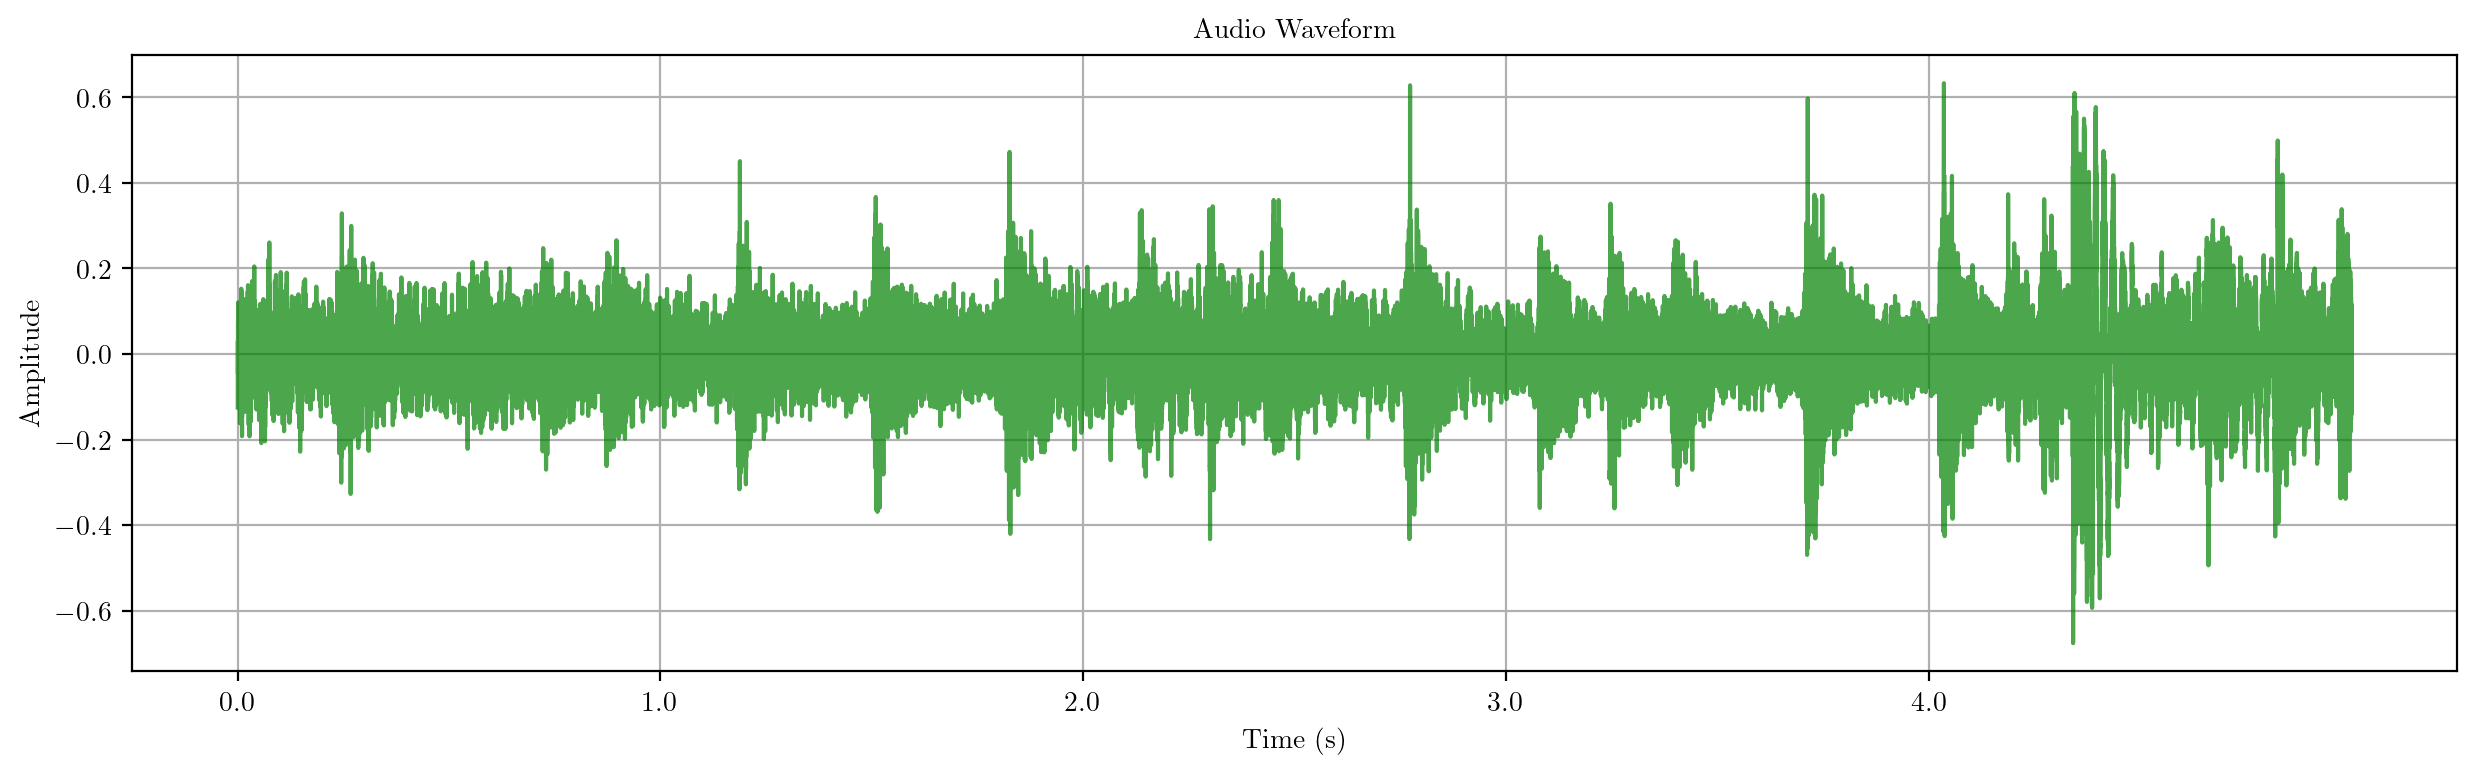

In [8]:
def audio_plot(audio, sr, clr, tl):
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color = clr, alpha = 0.7)
    plt.xticks(np.arange(0, audio.shape[0], sr), np.arange(0, audio.shape[0] / sr, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    plt.show()
audio_plot(audio, sr, 'green', 'Audio Waveform')

In [9]:
X = torch.arange(0, len(audio)).unsqueeze(1).float()
X = X / X.max() * 200 - 100
print(X.shape)
print(X)

torch.Size([220500, 1])
tensor([[-100.0000],
        [ -99.9991],
        [ -99.9982],
        ...,
        [  99.9982],
        [  99.9991],
        [ 100.0000]])


In [10]:
from sklearn.kernel_approximation import RBFSampler

def create_rff_features(X, num_features, sigma):
    # Set a random state to the sampler for repoducibility
    rff = RBFSampler(n_components = num_features, gamma = 1 / (2 * sigma**2), random_state = 13)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype = torch.float32)

In [16]:
num_features = 4000
sigma = 0.008

X_rff = create_rff_features(X, num_features, sigma)
print(X_rff.shape)
print(X_rff)

torch.Size([220500, 4000])
tensor([[-0.0196, -0.0113,  0.0097,  ..., -0.0004, -0.0181,  0.0200],
        [-0.0186, -0.0097,  0.0098,  ..., -0.0049, -0.0157,  0.0218],
        [-0.0176, -0.0079,  0.0099,  ..., -0.0092, -0.0129,  0.0224],
        ...,
        [ 0.0204,  0.0041,  0.0174,  ..., -0.0086,  0.0125, -0.0152],
        [ 0.0196,  0.0060,  0.0175,  ..., -0.0042,  0.0154, -0.0107],
        [ 0.0186,  0.0077,  0.0176,  ...,  0.0003,  0.0178, -0.0056]])


In [17]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_rff.numpy(), audio)

pred_audio = model.predict(X_rff.numpy())
print(pred_audio.shape)

(220500,)


In [18]:
Audio(pred_audio, rate = sr)

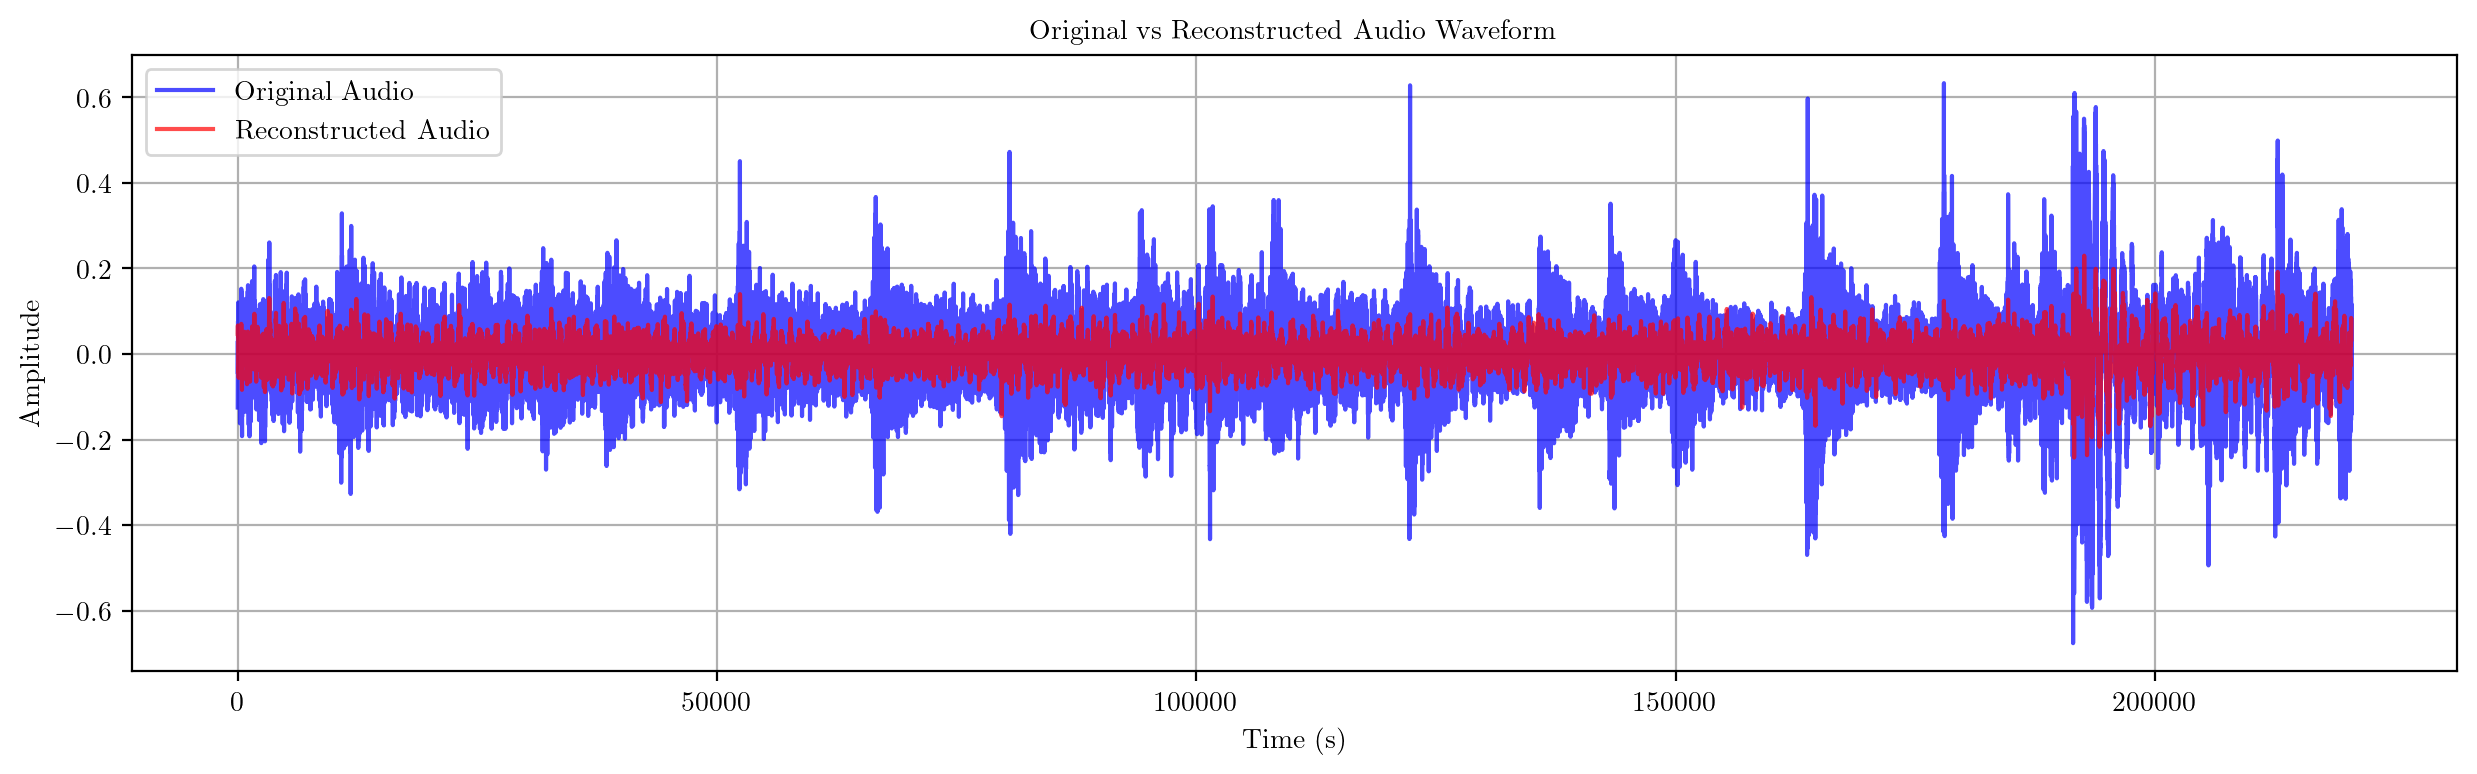

In [19]:
plt.figure(figsize=(15, 4))
plt.plot(audio, color = 'blue', alpha = 0.7, label = 'Original Audio')
plt.plot(pred_audio, color = 'red', alpha = 0.7, label = 'Reconstructed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform')
plt.grid()
plt.legend()
plt.show()

L1 and L2 Losses

In [15]:
np.linalg.norm(pred_audio - audio.numpy()), np.linalg.norm((pred_audio - audio.numpy()), ord = 1)

(35.43532, 12075.152)

In [25]:
def compute_rmse(tensor1, tensor2):

    mse = torch.mean((tensor1 - tensor2) ** 2)
    rmse = torch.sqrt(mse)
    return rmse.item()

def calculate_snr(signal, noisy_signal):

    signal_power = torch.mean(signal ** 2)
    noise_power = torch.mean((signal - noisy_signal) ** 2)
    snr = 10 * torch.log10(signal_power / noise_power)
    return snr.item()
rmse = compute_rmse(audio, pred_audio)
snr_value = calculate_snr(audio, pred_audio)
print(f"SNR: {snr_value} dB")
print(f"RMSE: {rmse}")

SNR: 1.2814830541610718 dB
RMSE: 0.06720855832099915
